In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from dataclasses import dataclass
from typing import List, Type, Dict, Optional


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from torchvision import datasets, transforms

## Permuted MNIST Task Generator

In [2]:
class PermutedMNIST:
    def __init__(self, perm):
        self.perm = perm
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.view(-1)[perm])
        ])

    def train_loader(self, batch_size=128):
        return torch.utils.data.DataLoader(
            datasets.MNIST("../data", train=True, download=True, transform=self.transform),
            batch_size=batch_size, shuffle=True)

    def test_loader(self, batch_size=1000):
        return torch.utils.data.DataLoader(
            datasets.MNIST("../data", train=False, transform=self.transform),
            batch_size=batch_size)

## CMS Optimizer

In [3]:
@dataclass
class CMSGroup:
    params: List[torch.nn.Parameter]
    lr: float
    chunk: int

class CMSOptimizer:
    def __init__(
        self,
        groups: List[CMSGroup],
        base_optim_cls: Type[Optimizer],
        base_optim_kwargs: Optional[Dict] = None,
    ):
        self.step_idx = 0
        self.groups = groups
        base_optim_kwargs = base_optim_kwargs or {}
        self.opts = [base_optim_cls(g.params, lr=g.lr, **base_optim_kwargs) for g in groups]
        
    @torch.no_grad()
    def step(self):
        self.step_idx += 1
        for opt, g in zip(self.opts, self.groups):
            if (self.step_idx % g.chunk) == 0:
                opt.step()

    def zero_grad(self):
        for opt, g in zip(self.opts, self.groups):
            if ((self.step_idx)% g.chunk) == 0:
                opt.zero_grad()
        

## Model

In [4]:
class MLP(nn.Module):
    def __init__(self, 
        input_dim=784,
        hidden_dims=[256, 128, 64],
        output_dim=10,
        ):
        super().__init__()
        assert len(hidden_dims) == 3
        self.slow = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
        )
        self.mid = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
        )
        self.fast = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU(),
            nn.Linear(hidden_dims[2], output_dim),
        )

    def forward(self, x):
        h = self.slow(x)
        h = self.mid(h)
        y = self.fast(h)
        return y

## Metrics

In [5]:
def forgetting_matrix(acc_matrix: np.ndarray) -> np.ndarray:
    T = acc_matrix.shape[0]
    F = np.zeros_like(acc_matrix)

    for i in range(T):          # task
        best_so_far = acc_matrix[i, i]  # first time task i is learned
        for j in range(i, T):   # after task j
            best_so_far = max(best_so_far, acc_matrix[i, j])
            F[i, j] = best_so_far - acc_matrix[i, j]

    return F

def compute_avg_forgetting(acc_matrix: np.ndarray) -> float:
    T = acc_matrix.shape[0]
    forgets = []
    for i in range(T - 1):
        best = acc_matrix[i, i:].max()
        final = acc_matrix[i, T - 1]
        forgets.append(best - final)
    return float(np.mean(forgets))

def compute_avg_accuracy(acc_matrix: np.ndarray) -> float:
    T = acc_matrix.shape[0]
    return float(acc_matrix[:, T - 1].mean())

## Experiment

In [6]:
def evaluate(model, loader, device) -> float:
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
    return correct / len(loader.dataset)

In [7]:
def run_permuted_mnist_cms_experiment(
    T=9,
    epochs_per_task=8,
    batch_size=128,
    hidden_dims=(256, 128, 64),
    base_lr=5e-4,
    periods=(4, 2, 1),
    device=None,
    seed=None,
    verbose=False,
):
    # --- device ---
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- reproducibility (optional) ---
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # --- datasets ---
    g = torch.Generator().manual_seed(seed) if seed is not None else None
    perms = [torch.randperm(784, generator=g) for _ in range(T)]
    tasks = [PermutedMNIST(p) for p in perms]

    loss_fn = nn.CrossEntropyLoss()

    # --- baseline ---
    baseline_mlp = MLP(784, list(hidden_dims), 10).to(device)
    baseline_optimizer = CMSOptimizer(
        groups=[CMSGroup(params=list(baseline_mlp.parameters()), lr=base_lr, chunk=1)],
        base_optim_cls=optim.Adam,
    )

    # --- CMS ---
    frequencies = [base_lr / p for p in periods]
    seq_cms = MLP(784, list(hidden_dims), 10).to(device)
    seq_cms_optimizer = CMSOptimizer(
        groups=[
            CMSGroup(params=list(seq_cms.slow.parameters()), lr=frequencies[0], chunk=periods[0]),
            CMSGroup(params=list(seq_cms.mid.parameters()),  lr=frequencies[1], chunk=periods[1]),
            CMSGroup(params=list(seq_cms.fast.parameters()), lr=frequencies[2], chunk=periods[2]),
        ],
        base_optim_cls=optim.Adam,
    )

    # --- results ---
    acc_matrix_baseline = np.zeros((T, T), dtype=np.float32)
    acc_matrix_cms      = np.zeros((T, T), dtype=np.float32)

    # --- train sequentially ---
    for current_t in range(T):
        train_loader = tasks[current_t].train_loader(batch_size=batch_size)

        baseline_mlp.train()
        seq_cms.train()

        for _ in range(epochs_per_task):
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                # baseline
                baseline_optimizer.zero_grad()
                loss = loss_fn(baseline_mlp(x), y)
                loss.backward()
                baseline_optimizer.step()

                # cms
                seq_cms_optimizer.zero_grad()
                loss = loss_fn(seq_cms(x), y)
                loss.backward()
                seq_cms_optimizer.step()

        # --- evaluation + optional printing ---
        if verbose:
            print("\nEvaluation after training task", current_t + 1)
            print("-" * 55)
            print(f"{'Eval Task':<10} | {'Baseline MLP':<15} | {'Seq CMS':<15}")
            print("-" * 55)

        for i in range(T):
            acc_matrix_baseline[i, current_t] = evaluate(
                baseline_mlp, tasks[i].test_loader(), device
            )
            acc_matrix_cms[i, current_t] = evaluate(
                seq_cms, tasks[i].test_loader(), device
            )

            if verbose:
                print(
                    f"{i+1:<10} | "
                    f"{acc_matrix_baseline[i, current_t]*100:>6.2f}%{'':<7} | "
                    f"{acc_matrix_cms[i, current_t]*100:>6.2f}%"
                )

        if verbose:
            print("-" * 55)

    return acc_matrix_baseline, acc_matrix_cms

def run_n_times(n_runs=5, seed=None, verbose=False, **kwargs):

    if verbose:
        print("\n" + "=" * 70)
        print("🚀 Running Permuted-MNIST Continual Learning Experiment")
        print(f"Total runs: {n_runs}")
        print("=" * 70)

    base_forgets, cms_forgets = [], []
    base_accs, cms_accs = [], []

    for k in range(n_runs):

        if verbose:
            print("\n" + "-" * 70)
            print(f"▶ Run {k + 1}/{n_runs}")
            print("-" * 70)

        run_seed = seed + k if seed is not None else None
        A_base, A_cms = run_permuted_mnist_cms_experiment(
            verbose=verbose,
            seed=run_seed,
            **kwargs
        )

        bF = compute_avg_forgetting(A_base)
        cF = compute_avg_forgetting(A_cms)
        bA = compute_avg_accuracy(A_base)
        cA = compute_avg_accuracy(A_cms)

        base_forgets.append(bF)
        cms_forgets.append(cF)
        base_accs.append(bA)
        cms_accs.append(cA)

        if verbose:
            print("\n📊 Run summary")
            print(f"  Baseline | Avg Acc: {bA*100:6.2f}% | Forgetting: {bF*100:6.2f}%")
            print(f"  CMS      | Avg Acc: {cA*100:6.2f}% | Forgetting: {cF*100:6.2f}%")

    report = {
        "baseline_avg_acc_mean":    float(np.mean(base_accs)),
        "baseline_avg_acc_std":     float(np.std(base_accs, ddof=1)) if n_runs > 1 else 0.0,
        "cms_avg_acc_mean":         float(np.mean(cms_accs)),
        "cms_avg_acc_std":          float(np.std(cms_accs, ddof=1)) if n_runs > 1 else 0.0,
        "baseline_forgetting_mean": float(np.mean(base_forgets)),
        "baseline_forgetting_std":  float(np.std(base_forgets, ddof=1)) if n_runs > 1 else 0.0,
        "cms_forgetting_mean":      float(np.mean(cms_forgets)),
        "cms_forgetting_std":       float(np.std(cms_forgets, ddof=1)) if n_runs > 1 else 0.0,
        "baseline_forgetting_all":  base_forgets,
        "cms_forgetting_all":       cms_forgets,
        "baseline_acc_all":         base_accs,
        "cms_acc_all":              cms_accs,
    }

    print("\n" + "=" * 70)
    print("✅ Final Continual Learning Report (mean ± std)")
    print("=" * 70)
    print(f"Average Accuracy  - Baseline: {report['baseline_avg_acc_mean']*100:6.2f}% ± {report['baseline_avg_acc_std']*100:5.2f}%")
    print(f"Average Accuracy  - CMS     : {report['cms_avg_acc_mean']*100:6.2f}% ± {report['cms_avg_acc_std']*100:5.2f}%")
    print(f"Avg Forgetting    - Baseline: {report['baseline_forgetting_mean']*100:6.2f}% ± {report['baseline_forgetting_std']*100:5.2f}%")
    print(f"Avg Forgetting    - CMS     : {report['cms_forgetting_mean']*100:6.2f}% ± {report['cms_forgetting_std']*100:5.2f}%")
    print("=" * 70)

    return report

In [8]:
n_runs=5
seed=0
verbose=True
T=9
epochs_per_task=8
batch_size=128
base_lr=5e-4
periods=(4,2,1)

In [9]:
report = run_n_times(
    n_runs=n_runs,
    seed=seed,
    verbose=verbose,
    T=T,
    epochs_per_task=epochs_per_task,
    batch_size=batch_size,
    base_lr=base_lr,
    periods=periods,
)


🚀 Running Permuted-MNIST Continual Learning Experiment
Total runs: 5

----------------------------------------------------------------------
▶ Run 1/5
----------------------------------------------------------------------

Evaluation after training task 1
-------------------------------------------------------
Eval Task  | Baseline MLP    | Seq CMS        
-------------------------------------------------------
1          |  97.63%        |  96.90%
2          |   9.21%        |  11.06%
3          |  12.97%        |  11.19%
4          |   9.96%        |  10.52%
5          |  11.23%        |  10.57%
6          |   7.83%        |  11.41%
7          |   7.91%        |   9.45%
8          |   8.79%        |  12.32%
9          |   7.00%        |  10.10%
-------------------------------------------------------

Evaluation after training task 2
-------------------------------------------------------
Eval Task  | Baseline MLP    | Seq CMS        
-------------------------------------------------

In [10]:
# Statistical significance test for forgetting
baseline = report["baseline_forgetting_all"]
cms = report["cms_forgetting_all"]
t_stat, p_value = ttest_rel(baseline, cms)
print("Statistical significance test for forgetting")
print("t-statistic :", t_stat)
print("p-value     :", p_value)

Statistical significance test for forgetting
t-statistic : 4.800852715263972
p-value     : 0.008642775933501212


In [13]:
# Statistical significance test for average accuracy
baseline = report["baseline_acc_all"]
cms = report["cms_acc_all"]
t_stat_acc, p_value_acc = ttest_rel(baseline, cms)
print("Statistical significance test for average accuracy")
print("t-statistic :", t_stat_acc)
print("p-value     :", p_value_acc)

Statistical significance test for average accuracy
t-statistic : -4.559011140803548
p-value     : 0.010346596419994691


## Plotting

In [23]:
def plot_accuracy_evolution(acc_matrix_baseline_mlp, acc_matrix_seq_cms, max_cols=3):
    num_tasks = acc_matrix_baseline_mlp.shape[0]
    cols = min(max_cols, num_tasks)
    rows = math.ceil(num_tasks / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = np.array(axes).reshape(-1) 

    x = np.arange(1, num_tasks + 1)
    for i, t in enumerate(range(num_tasks)):
        ax = axes[i]
        ax.plot(x, acc_matrix_baseline_mlp[t], marker="o")
        ax.plot(x, acc_matrix_seq_cms[t], marker="o")
        ax.set_title(f"Task {t+1}")
        ax.set_xlabel("Eval Task")
        ax.set_ylabel("Accuracy")
        
    fig.legend(["Baseline MLP", "Sequential CMS"], loc="lower center", ncol=2)
    fig.suptitle(f"Accuracy evolution per task", fontsize=14)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

def plot_task_forgetting(forget_matrix_baseline_mlp, forget_matrix_seq_cms, max_cols=3):
    num_tasks = forget_matrix_baseline_mlp.shape[0]
    cols = min(max_cols, num_tasks)
    rows = math.ceil(num_tasks / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = np.array(axes).reshape(-1) 

    for i, t in enumerate(range(num_tasks)):
        x = list(range(t, num_tasks))
        ax = axes[i]
        ax.plot(x, forget_matrix_baseline_mlp[t, t:], marker="o")
        ax.plot(x, forget_matrix_seq_cms[t, t:], marker="o")
        ax.set_title(f"Task {t+1}")
        ax.set_xlabel("Task")
        ax.set_ylabel("Task Forgetting")
        
    fig.legend(["Baseline MLP", "Sequential CMS"], loc="lower center", ncol=2)
    fig.suptitle(f"Task Forgetting evolution per task", fontsize=14)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

def plot_cumulative_forgetting(forget_matrix_baseline_mlp, forget_matrix_seq_cms, max_cols=3):
    num_tasks = forget_matrix_baseline_mlp.shape[0]
    cols = min(max_cols, num_tasks)
    rows = math.ceil(num_tasks / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = np.array(axes).reshape(-1) 

    for i, t in enumerate(range(num_tasks)):
        x = list(range(t, num_tasks))
        ax = axes[i]
        ax.plot(x, np.cumsum(forget_matrix_baseline_mlp[t, t:]), marker="o")
        ax.plot(x, np.cumsum(forget_matrix_seq_cms[t, t:]), marker="o")
        ax.set_title(f"Task {t+1}")
        ax.set_xlabel("Task")
        ax.set_ylabel("Task Forgetting")
        
    fig.legend(["Baseline MLP", "Sequential CMS"], loc="lower center", ncol=2)
    fig.suptitle(f"Cumulative Forgetting per task", fontsize=14)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


In [ ]:
A_base, A_cms = run_permuted_mnist_cms_experiment(
    seed=seed,
    verbose=verbose,
    T=T,
    epochs_per_task=epochs_per_task,
    batch_size=batch_size,
    base_lr=base_lr,
    periods=periods,
)


Evaluation after training task 1
-------------------------------------------------------
Eval Task  | Baseline MLP    | Seq CMS        
-------------------------------------------------------
1          |  97.63%        |  96.90%
2          |   9.21%        |  11.06%
3          |  12.97%        |  11.19%
4          |   9.96%        |  10.52%
5          |  11.23%        |  10.57%
6          |   7.83%        |  11.41%
7          |   7.91%        |   9.45%
8          |   8.79%        |  12.32%
9          |   7.00%        |  10.10%
-------------------------------------------------------

Evaluation after training task 2
-------------------------------------------------------
Eval Task  | Baseline MLP    | Seq CMS        
-------------------------------------------------------
1          |  85.99%        |  90.15%
2          |  97.55%        |  97.22%
3          |  10.53%        |  10.43%
4          |   8.78%        |  12.34%
5          |   9.20%        |   7.34%
6          |  10.67%      

In [22]:
F_base = forgetting_matrix(A_base)
F_cms = forgetting_matrix(A_cms)
F_cms.shape

(9, 9)

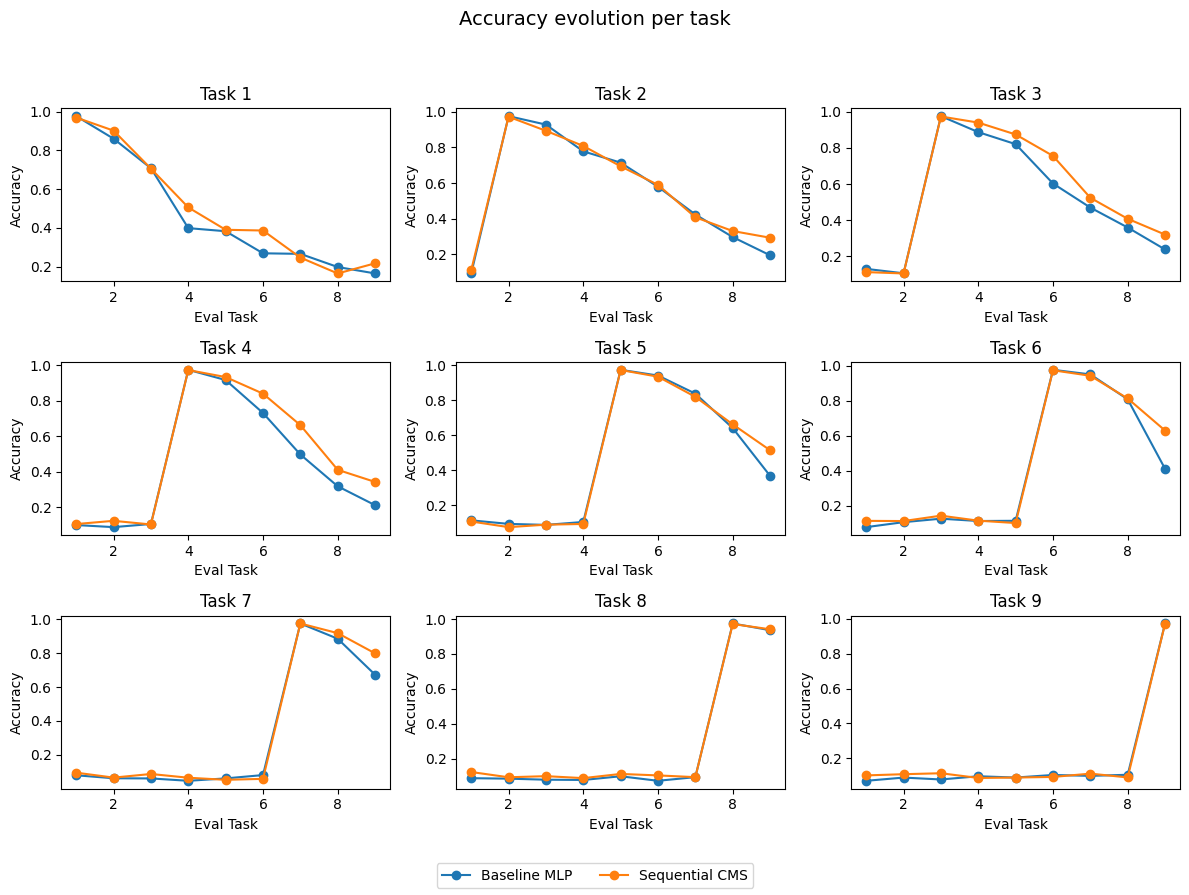

In [18]:
plot_accuracy_evolution(A_base, A_cms)

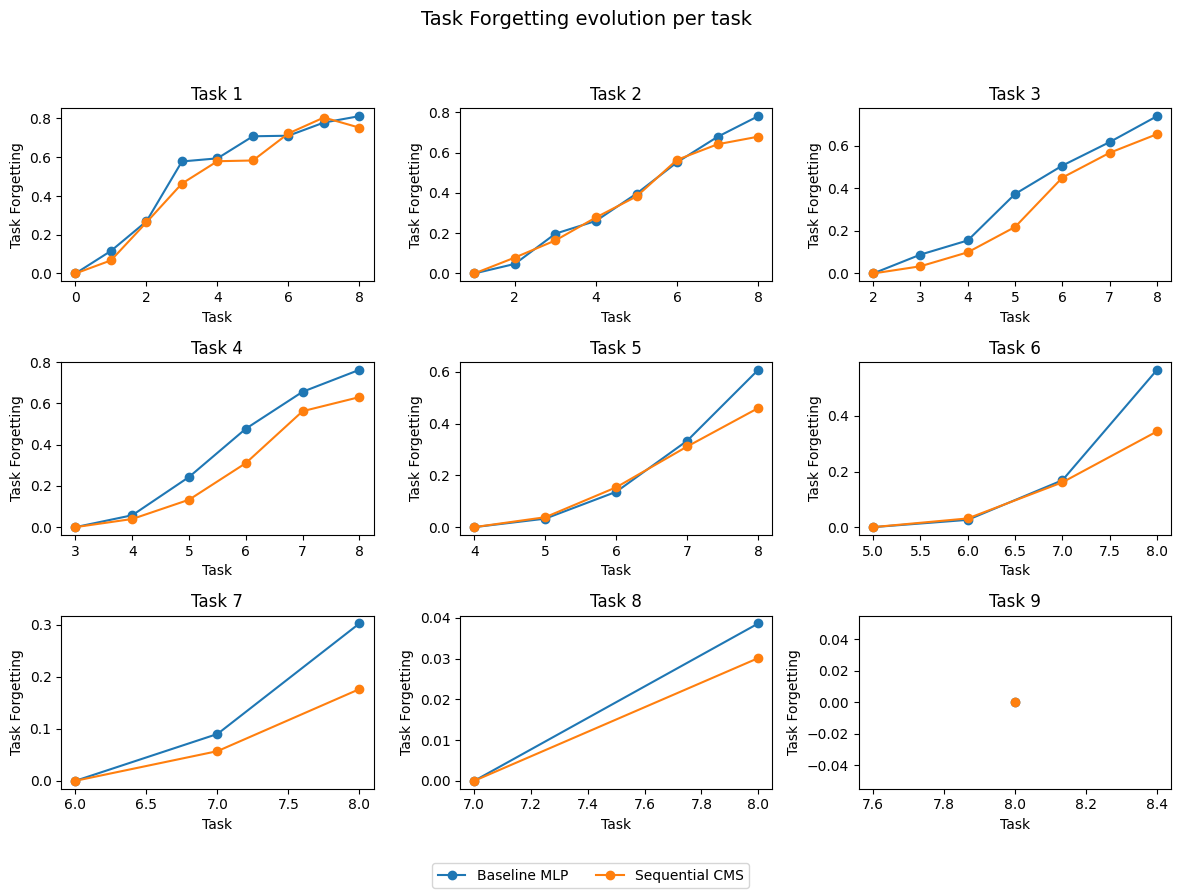

In [24]:
plot_task_forgetting(F_base, F_cms)

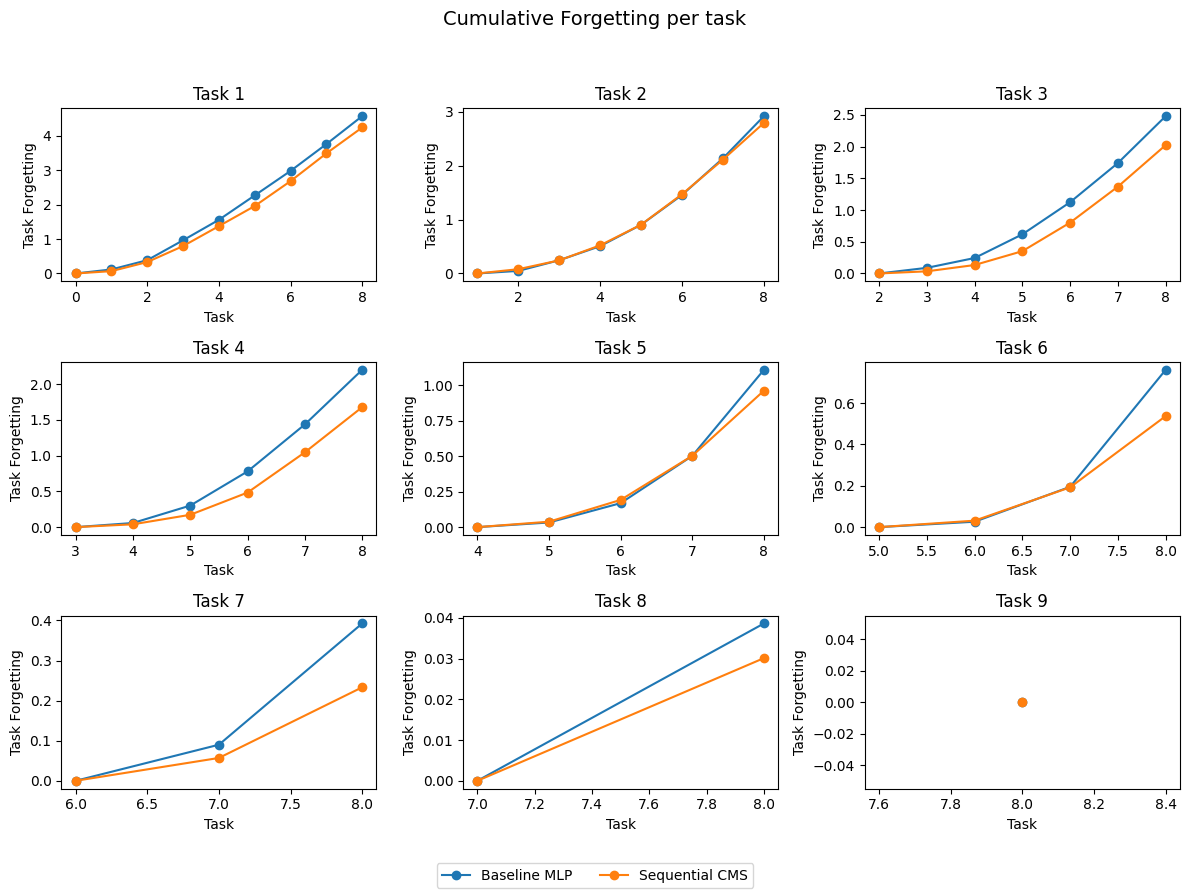

In [25]:
plot_cumulative_forgetting(F_base, F_cms)